In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# %matplotlib inline

In [2]:
class Agent():
    def __init__(self, x=0.0, y=0.0, vx=0.0, vy=0.0, v_min=0.0, v_max=10.0, psi=0.0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.v_min = v_min
        self.v_max = v_max
        self.psi = psi
        
    def update(self, ax=0.0, ay=0.0, vpsi=0.0, dt=0.1):
        # Increment velocity
        self.vx += ax * dt
        self.vy += ay * dt
        
        # Limit velocity
        v_norm = np.sqrt(self.vx**2 + self.vy**2)
        if v_norm < self.v_min:
            self.vx = self.vx * self.v_min / v_norm
            self.vy = self.vy * self.v_min / v_norm
        elif v_norm > self.v_max:
            self.vx = self.vx * self.v_max / v_norm
            self.vy = self.vy * self.v_max / v_norm
                
        # Increment position
        self.x += self.vx * dt
        self.y += self.vy * dt
        
        # Increment heading
        self.psi += vpsi * dt
        
def agent_marker(angle):
    a = np.array([[-1.0,-1.0],
                  [-0.5, 0.0],
                  [-1.0, 1.0],
                  [ 1.0, 0.0]])
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    return R.dot(a.T).T  

def plot_agent(ax, agent, **args):
    return ax.plot([agent.x], [agent.y], marker=agent_marker(agent.psi), **args)[0]

In [65]:
class Navigation:
    def __init__(self, 
                 waypoints=np.array([[x, y, 0.0]
                                      for x, y, in zip([-1, 1, 1, -1], 
                                                       [-1, -1, 1, 1])]), 
                 radius=0.1):
        self.waypoints = waypoints
        self.radius = radius
        self.index = 0
    
    def current(self):
        return self.waypoints[self.index]
    
    def update(self, agent):
        agent_pos = np.array([agent.x, agent.y, 0.0])
        if (np.linalg.norm(agent_pos - self.current()) < self.radius):
            self.index = (self.index + 1) % len(self.waypoints)


In [82]:
# Initialize an agent
agent = Agent(x=-2.0, y=0.0,
              vx=0.0, vy=0.0)

# Vector field navigation
navigation = Navigation()

# Timing
dt = 0.05
n_steps = 300

# Prepare trajectory
trajectory = np.zeros([n_steps, 3])

# Update agents state
for k in range(n_steps):
    # Navigation
    navigation.update(agent)
    
    # Direct-to velocity command
    vel_ref = navigation.current() - np.array([agent.x, agent.y, 0.0])
    vel_ref = max(1.0, np.linalg.norm(vel_ref)) * vel_ref / np.linalg.norm(vel_ref)
    accel = 5.0 * (vel_ref - np.array([agent.vx, agent.vy, 0.0]))
    
    # Wind
#     accel += 3.0 * np.array([0.0, -1.0, 0.0])
    
    # Update agent state
    agent.update(ax=accel[0], ay=accel[1], dt=dt)

    # coordinated turn
    agent.psi = np.arctan2(agent.vy, agent.vx)

    # save state
    trajectory[k] = [agent.x, agent.y, agent.psi]

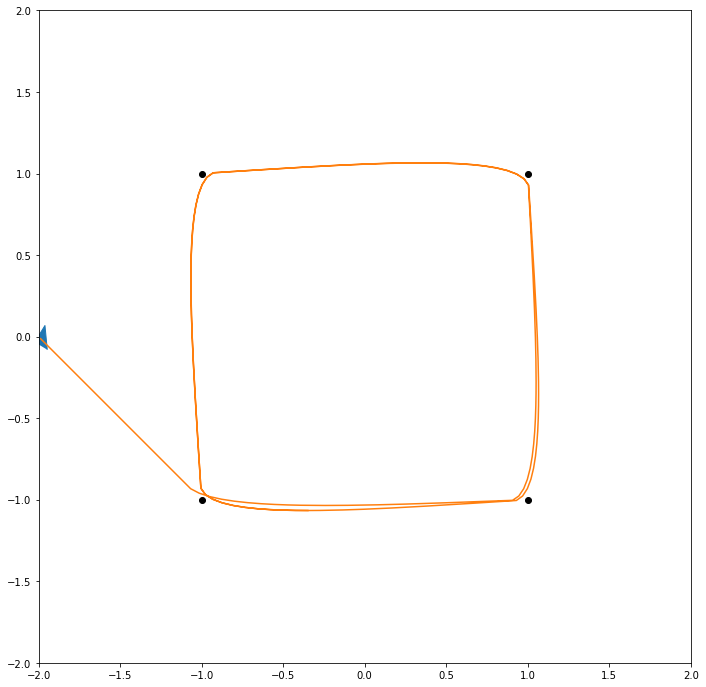

In [83]:
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

In [84]:
# Animated plot
fig, ax = plt.subplots(1, 1, figsize=[12, 12])
ax.axis('square')
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])

# Plot circles
ax.plot(navigation.waypoints[:, 0], 
        navigation.waypoints[:, 1],
        'ok')

# Re-initialize navigation
navigation.index = 0

# Trajectory - to be animated
lines, = ax.plot(trajectory[:1, 0], trajectory[:1, 1])

# Agent marker - to be animated
marker = plot_agent(ax, 
                    Agent(x=trajectory[0, 0], y=trajectory[0, 1], psi=trajectory[0, 2]), 
                    markersize=30,
                    alpha=1.0,
                    color='C0')

# ax.quiver([-1.5, -0.5, 0.5, 1.5], 
#           [ 1.5,  1.5, 1.5, 1.5], 
#           [   0,    0,   0,   0], 
#           [  -2,   -2,  -2,  -2], 
#           color='lightgrey')

# animate function
def animate(i):
    # Update trails
    start_i = 0
    lines.set_data(trajectory[start_i:i, 0].T, 
                   trajectory[start_i:i, 1].T)
    
    # Update markers
    marker.set_data(trajectory[i, 0], 
                    trajectory[i, 1])
    marker.set_marker(agent_marker(trajectory[i, 2]))

    agent.x = trajectory[i, 0]
    agent.y = trajectory[i, 1]
    navigation.update(agent)
   
    return (lines, marker)

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=n_steps, 
                               interval=20, blit=False)

plt.close(fig)

anim

In [85]:
anim.save('waypoint_navigation_dpi300.mp4', dpi=300)